In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import bdb  # import the bdb module
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader


# Example
>   Z~N(0,1),
> 
>  X=gen_x()=Sign(Z)
> 
>  epsilon~N(0,var),
> 
>  Y=gen_y(X)=X+epsilon

# Interest

> Estimate MI(X,Y)

In [3]:
# data
var = 0.2

def func(x):
    return x

def gen_x():
    return np.sign(np.random.normal(0.,1.,[data_size,dim]))

def gen_y(x):
    return func(x)+np.random.normal(0.,np.sqrt(var),[data_size,dim])

In [4]:
# Manual code to compute Exact MI true (Only applicable for this example).
## 

data_size = 100
dim=1


x=gen_x()
y=gen_y(x)
p_y_x=np.exp(-(y-x)**2/(2*var))
p_y_x_minus=np.exp(-(y+1)**2/(2*var))
p_y_x_plus=np.exp(-(y-1)**2/(2*var))
mi=np.average(np.log(p_y_x/(0.5*p_y_x_minus+0.5*p_y_x_plus)))
mi

0.620410342401145

# Using Simple Empirical approach in computing MI numerically

In [13]:
# Computing Mutual Information (empirically)
import numpy as np
def computeMI(x, y):
    sum_mi = 0.0
    x_value_list = np.unique(x)
    y_value_list = np.unique(y)
    Px = np.array([ len(x[x==xval])/float(len(x)) for xval in x_value_list ]) #P(x)
    Py = np.array([ len(y[y==yval])/float(len(y)) for yval in y_value_list ]) #P(y)
    for i in range(len(x_value_list)):
        if Px[i] ==0.:
            continue
        sy = y[x == x_value_list[i]]
        if len(sy)== 0:
            continue
        pxy = np.array([len(sy[sy==yval])/float(len(y))  for yval in y_value_list]) #p(x,y)
        t = pxy[Py>0.]/Py[Py>0.] /Px[i] # log(P(x,y)/( P(x)*P(y))
        sum_mi += sum(pxy[t>0]*np.log( t[t>0]) ) # sum ( P(x,y)* log(P(x,y)/( P(x)*P(y)) )
    return sum_mi
computeMI(x, y)

0.6913460990017387

## MI estimation on CPU using MINE paper 

In [7]:
# MI estimation on GPU using MINE paper (the Best)
class ConcatLayer(nn.Module):
    def __init__(self, dim=1):
        super().__init__()
        self.dim = dim

    def forward(self, x, y):
        return torch.cat((x, y), self.dim)

class CustomSequential(nn.Sequential):
    def forward(self, *input):
        for module in self._modules.values():
            if isinstance(input, tuple):
                input = module(*input)
            else:
                input = module(input)
        return input

class T(nn.Module):
    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.layers = CustomSequential(ConcatLayer(), nn.Linear(x_dim + z_dim, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 1))

    def forward(self, x, z):
        return self.layers(x, z)

#----End of defining network T
#

#.............
#>>>> Making T-network using Convolutional networks:
class T_network_Conv(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5,
                               stride=2, padding=2, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5,
                               stride=2, padding=2, bias=False)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5,
                               stride=2, padding=2, bias=False)

        self.fc1 = nn.Linear(8 * 8 * 64, 1)

        self.z_linear1 = nn.Linear(z_dim, 16)
        self.z_linear2 = nn.Linear(z_dim, 32)
        self.z_linear3 = nn.Linear(z_dim, 64)

    def xz_block(self, x, z, x_layer, z_layer):
        x_out = x_layer(x)
        z_map = z_layer(z).unsqueeze(-1).unsqueeze(-1).expand_as(x_out)
        return F.elu(x_out + z_map)

    def forward(self, x, z):
        x = self.xz_block(x, z, self.conv1, self.z_linear1)
        x = self.xz_block(x, z, self.conv2, self.z_linear2)
        x = self.xz_block(x, z, self.conv3, self.z_linear3)

        x = x.view(x.size(0), -1)
        return self.fc1(x)

#----End of defining T_network_Conv
#|||||||||||||||||||||||||||||

KL=True
JS=False
dim1=1 #1000 #4096
dim2=1 #1000 # 1000
#dim=1000
n_epoch =1500#500
data_size = 100  # Also works well for size=4
Tmodel=T(dim1,dim2).cuda()  # Add .cuda() to move the Tmodel to GPU
#Tmodel_conv=T_network_Conv(dim2).cuda()
optimizer = torch.optim.Adam(Tmodel.parameters(), lr=0.0002)

# Active when use 'Tmodel_conv'
#optimizer = torch.optim.Adam(Tmodel_conv.parameters(), lr=0.0002)

plot_loss0 = []

for epoch in tqdm(range(n_epoch)):
    x_sample= gen_x() #np.random.normal(0.,1.,[data_size,dim1])#joint_samples[:, 0].reshape(data_size,1)#gen_x()
    y_sample= gen_y(x_sample) #np.random.normal(0.,1.,[data_size,dim2])#gen_y(x_sample)
    y_shuffle=np.random.permutation(y_sample)

    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor).cuda(), requires_grad = True)  # Add .cuda() to move input variables to GPU
    y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor).cuda(), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor).cuda(), requires_grad = True)

    pred_xy = Tmodel(x_sample, y_sample) #Tmodel_conv(x_sample.reshape(data_size,1,64,64),y_sample) #Tmodel(x_sample, y_sample)
    pred_x_y = Tmodel(x_sample, y_shuffle) #Tmodel_conv(x_sample.reshape(data_size,1,64,64),y_shuffle) #Tmodel(x_sample, y_shuffle)

    if KL:
        ret = torch.mean(pred_xy) - (torch.logsumexp(pred_x_y,0)-np.log(pred_x_y.shape[0]))
        loss = - ret  # maximize
    if JS:
        ret = torch.mean(-F.softplus(-pred_xy, beta=1, threshold=20)+np.log(2)) - torch.mean(F.softplus(-pred_x_y, beta=1, threshold=20)-np.log(2)+pred_x_y)
        loss = - ret  # maximize
    plot_loss0.append(loss.data.cpu().numpy())  # Add .cpu() to move the loss back to CPU
    Tmodel.zero_grad()
    #Tmodel_conv.zero_grad()
    bdb.set_trace()
    loss.backward()
    optimizer.step()

100%|██████████| 1500/1500 [00:11<00:00, 132.88it/s]


Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'MI Estimation')

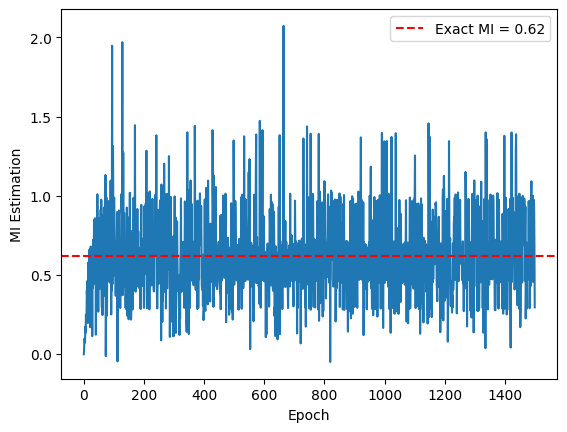

In [8]:
plot_x0 = np.arange(len(plot_loss0))
plot_x0=np.array(plot_x0,dtype=np.float32)
plot_y0 = np.array(plot_loss0).reshape(-1,)
plot_y0=np.array(plot_y0,dtype=np.float32)
plt.plot(plot_x0,-plot_y0)
plt.axhline(y=mi, color='r', linestyle='--', label=f"Exact MI = {mi:.2f}")
plt.xlabel("Epoch")
plt.ylabel("MI Estimation")
plt.legend()



In [12]:
## The MI estimation at 1499 epoch

-plot_y0[1498]

0.6871388

## Implementing on GPU to Speed up the computation

In [27]:
# MI estimation on GPU using MINE paper (the Best)
class ConcatLayer(nn.Module):
    def __init__(self, dim=1):
        super().__init__()
        self.dim = dim

    def forward(self, x, y):
        return torch.cat((x, y), self.dim)

class CustomSequential(nn.Sequential):
    def forward(self, *input):
        for module in self._modules.values():
            if isinstance(input, tuple):
                input = module(*input)
            else:
                input = module(input)
        return input

class T(nn.Module):
    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.layers = CustomSequential(ConcatLayer(), nn.Linear(x_dim + z_dim, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 1))

    def forward(self, x, z):
        return self.layers(x, z)

#----End of defining network T
#

#.............
#>>>> Making T-network using Convolutional networks:
class T_network_Conv(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5,
                               stride=2, padding=2, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5,
                               stride=2, padding=2, bias=False)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5,
                               stride=2, padding=2, bias=False)

        self.fc1 = nn.Linear(8 * 8 * 64, 1)

        self.z_linear1 = nn.Linear(z_dim, 16)
        self.z_linear2 = nn.Linear(z_dim, 32)
        self.z_linear3 = nn.Linear(z_dim, 64)

    def xz_block(self, x, z, x_layer, z_layer):
        x_out = x_layer(x)
        z_map = z_layer(z).unsqueeze(-1).unsqueeze(-1).expand_as(x_out)
        return F.elu(x_out + z_map)

    def forward(self, x, z):
        x = self.xz_block(x, z, self.conv1, self.z_linear1)
        x = self.xz_block(x, z, self.conv2, self.z_linear2)
        x = self.xz_block(x, z, self.conv3, self.z_linear3)

        x = x.view(x.size(0), -1)
        return self.fc1(x)

#----End of defining T_network_Conv
#|||||||||||||||||||||||||||||

KL=True
JS=False
dim1=1 #1000 #4096
dim2=1 #1000 # 1000
#dim=1000
n_epoch =1500#500
data_size = 16  # Also works well for size=4
Tmodel=T(dim1,dim2).cuda()  # Add .cuda() to move the Tmodel to GPU
#Tmodel_conv=T_network_Conv(dim2).cuda()
optimizer = torch.optim.Adam(Tmodel.parameters(), lr=0.0002)

# Active when use 'Tmodel_conv'
#optimizer = torch.optim.Adam(Tmodel_conv.parameters(), lr=0.0002)

plot_loss0 = []

for epoch in tqdm(range(n_epoch)):
    x_sample= gen_x() #np.random.normal(0.,1.,[data_size,dim1])#joint_samples[:, 0].reshape(data_size,1)#gen_x()
    y_sample= gen_y(x_sample) #np.random.normal(0.,1.,[data_size,dim2])#gen_y(x_sample)
    y_shuffle=np.random.permutation(y_sample)

    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor).cuda(), requires_grad = True)  # Add .cuda() to move input variables to GPU
    y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor).cuda(), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor).cuda(), requires_grad = True)

    pred_xy = Tmodel(x_sample, y_sample) #Tmodel_conv(x_sample.reshape(data_size,1,64,64),y_sample) #Tmodel(x_sample, y_sample)
    pred_x_y = Tmodel(x_sample, y_shuffle) #Tmodel_conv(x_sample.reshape(data_size,1,64,64),y_shuffle) #Tmodel(x_sample, y_shuffle)

    if KL:
        ret = torch.mean(pred_xy) - (torch.logsumexp(pred_x_y,0)-np.log(pred_x_y.shape[0]))
        loss = - ret  # maximize
    if JS:
        ret = torch.mean(-F.softplus(-pred_xy, beta=1, threshold=20)+np.log(2)) - torch.mean(F.softplus(-pred_x_y, beta=1, threshold=20)-np.log(2)+pred_x_y)
        loss = - ret  # maximize
    plot_loss0.append(loss.data.cpu().numpy())  # Add .cpu() to move the loss back to CPU
    Tmodel.zero_grad()
    #Tmodel_conv.zero_grad()
    bdb.set_trace()
    loss.backward()
    optimizer.step()

100%|██████████| 1500/1500 [00:13<00:00, 112.12it/s]
